In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, roc_auc_score, log_loss, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, cross_val_score,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier, GradientBoostingClassifier,BaggingClassifier,StackingClassifier


# Replace 'your_file.csv' with the path to your CSV file.
csv_file = 'in-vehicle-coupon-recommendation.csv'

# Load the CSV file into a pandas DataFrame.
df = pd.read_csv(csv_file)
df = df.drop_duplicates()
print("Shape of dataset after removing duplicates:",df.shape)

# Drop the 'car' , 'toCoupon_GEQ5min' and 'direction_opp' columns
df = df.drop(['car', 'toCoupon_GEQ5min','direction_opp'], axis=1)

weather_col = 'weather'
temp_col = 'temperature'


# Fill missing values with the mode (most common value) of each column
df = df.fillna(df.mode().iloc[0])
# Step 1: Calculate acceptance ratio for each occupation
acceptance_ratio = df.groupby('occupation')['Y'].mean().sort_values()

Shape of dataset after removing duplicates: (12610, 26)


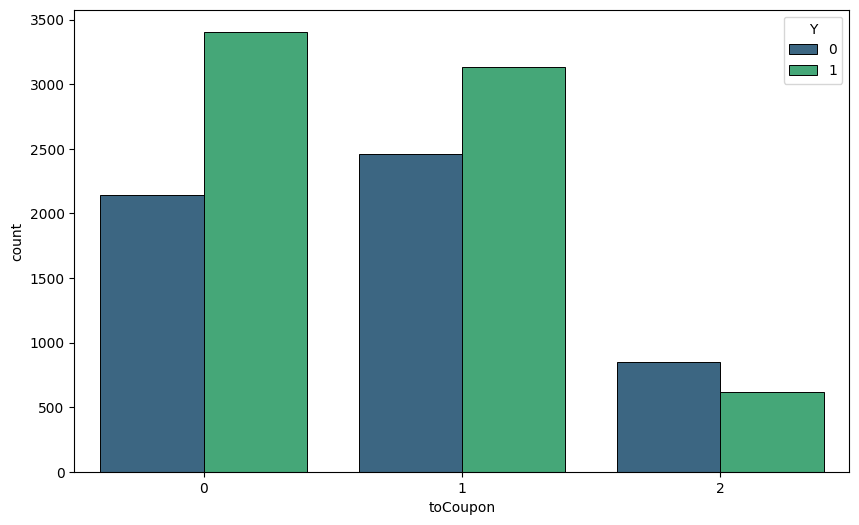

In [36]:
# Step 2: Bin occupations based on acceptance ratio
# Using quantiles as dynamic boundaries. Adjust according to your needs.
bins = [
    acceptance_ratio.min(),
    acceptance_ratio.quantile(0.2),
    acceptance_ratio.quantile(0.4),
    acceptance_ratio.quantile(0.6),
    acceptance_ratio.quantile(0.8),
    acceptance_ratio.max()
]

bin_labels = ['low', 'medium_low', 'medium', 'medium_high', 'high']

# Assign bin labels
occupation_bins = pd.cut(acceptance_ratio, bins=bins, labels=bin_labels, include_lowest=True)

# Step 3: Map original occupation to occupation_class
df['occupation'] = df['occupation'].map(occupation_bins.to_dict())


# Define a function to combine the features into 'toCoupon'
def combine_features(row):
    if row['toCoupon_GEQ15min'] == 0:  # driving distance <= 15 min
        return 0
    elif row['toCoupon_GEQ25min'] == 0 :  # driving distance > 15 min and <= 25 min
        return 1
    else:  # driving distance > 25 min
        return 2

# Apply the function to the dataframe
df['toCoupon'] = df.apply(combine_features, axis=1)

# Optionally, drop the original features
df = df.drop(['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], axis=1)
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='toCoupon', hue='Y', palette='viridis', edgecolor='black', linewidth=0.7)


# Feature Extraction for 'passenger_destination' from 'time' and 'destination'
df['time_destination'] = df['time'].astype(str) + "_" + df['destination'].astype(str)

# Feature Extraction for 'marital_hasChildren' from 'maritalStatus' and 'has_children'
df['marital_hasChildren'] = df['maritalStatus'].astype(str) + "_" + df['has_children'].astype(str)

# Feature Extraction for 'temperature_weather' from 'temperature' and 'weather'
df['temperature_weather'] = df['temperature'].astype(str) + "_" + df['weather'].astype(str)


df = df.drop(['time', 'destination', 'maritalStatus', 'has_children', 'temperature', 'weather'], axis=1)



# Define order for the ordinal variables

age_order = {'below21': 0, '21': 1, '26': 2, '31': 3, '36': 4, '41': 5, '46': 6, '50plus': 7}
education_order = {'Some High School': 0, 'High School Graduate': 1, 'Some college - no degree': 2, 'Associates degree': 3, 'Bachelors degree': 4, 'Graduate degree (Masters or Doctorate)': 5}
income_order = {'Less than $12500': 0, '$12500 - $24999': 1, '$25000 - $37499': 2, '$37500 - $49999': 3, '$50000 - $62499': 4, '$62500 - $74999': 5, '$75000 - $87499': 6, '$87500 - $99999': 7, '$100000 or More': 8}
frequency_order = {'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4}
occupation_order= { 'medium_low':1, 'high':4, 'medium_high':3, 'low' :0,'medium':2}

# Replace the values based on the order
df['age'] = df['age'].replace(age_order)
df['education'] = df['education'].replace(education_order)
df['income'] = df['income'].replace(income_order)
df['occupation']=df['occupation'].replace(occupation_order)

# Encoding frequency-like features
for col in ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']:
    df[col] = df[col].replace(frequency_order)


# 1. One-Hot Encoding
onehot_cols = ['passanger', 'coupon', 'marital_hasChildren', 'temperature_weather', 'time_destination']
encoder = OneHotEncoder(sparse_output=False, drop='first')  
encoded_cols = pd.DataFrame(encoder.fit_transform(df[onehot_cols]))

# Reset indices to ensure alignment when concatenating
encoded_cols.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Use appropriate column names for one-hot encoded columns
encoded_cols.columns = encoder.get_feature_names_out(onehot_cols)

# Concatenate the original dataframe and the one-hot encoded columns
df = pd.concat([df, encoded_cols], axis=1)

# Drop the original columns that were one-hot encoded
df.drop(onehot_cols, axis=1, inplace=True)

# 2. Binary Encoding
df['expiration'] = df['expiration'].map({'2h': 0, '1d': 1})
# Note: 'Y' and 'direction_same' are already binary, no encoding needed

# 3. Label Encoding
label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])  # 0 for Female and 1 for Male

# Dataframe Modelling

In [40]:
# Define features (X) and target (y)
X = df.drop("Y", axis=1)
y = df["Y"]
X = X.rename(columns={'coupon_Restaurant(<20)': 'coupon_Restaurant(20)'})


# Split data into 75% train+validation and 25% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize a k-fold cross-validator (e.g., 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression

In [ ]:
# Define hyperparameters to tune
param_grid = [
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
]

# Initialize the base Logistic Regression model
clf_logistic_regression = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence

# Initialize GridSearchCV
grid_search = GridSearchCV(clf_logistic_regression, param_grid, cv=kf, scoring='accuracy')

# Perform GridSearch on training+validation set
grid_search.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

# Use the best model to make predictions on the test set
best_clf = grid_search.best_estimator_
y_test_preds = best_clf.predict(X_test)
# Evaluating the model

# Accuracy
print(" clf_logistic_regression Validation Accuracy:", accuracy_score(y_test, y_test_preds))

# Precision
print("clf_logistic_regression Validation Precision:", precision_score(y_test, y_test_preds))

# Recall
print("clf_logistic_regression Validation Recall:", recall_score(y_test, y_test_preds))

# ROC-AUC for probability scores
y_test_prob = best_clf.predict_proba(X_test)[:, 1]
print("clf_logistic_regression ROC-AUC:", roc_auc_score(y_test, y_test_prob))

# Log Loss
print("clf_logistic_regression Log Loss:", log_loss(y_test, y_test_prob))

# AUC Score (using roc_curve function)
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
print("clf_logistic_regression AUC Score:", auc(fpr, tpr))

# K-Nearest Neighbor

In [ ]:
# Define hyperparameters to tune for KNN
knn_params = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN classifier
clf_knn = KNeighborsClassifier()

# Initialize GridSearchCV for KNN
grid_search_knn = GridSearchCV(clf_knn, knn_params, cv=kf, scoring='accuracy')

# Perform GridSearch on training+validation set
grid_search_knn.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for KNN
print(f"KNN Best Parameters: {grid_search_knn.best_params_}")
print(f"KNN Best Cross-Validation Accuracy: {grid_search_knn.best_score_}")

# Use the best KNN model to make predictions on the test set
best_knn = grid_search_knn.best_estimator_
y_test_preds_knn = best_knn.predict(X_test)

# Evaluating the KNN model

# Accuracy
print("KNN Validation Accuracy:", accuracy_score(y_test, y_test_preds_knn))

# Precision
print("KNN Validation Precision:", precision_score(y_test, y_test_preds_knn))

# Recall
print("KNN Validation Recall:", recall_score(y_test, y_test_preds_knn))

# ROC-AUC for probability scores
y_test_prob_knn = best_knn.predict_proba(X_test)[:, 1]
print("KNN ROC-AUC:", roc_auc_score(y_test, y_test_prob_knn))

# Log Loss
print("KNN Log Loss:", log_loss(y_test, y_test_prob_knn))

# AUC Score (using roc_curve function)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_test_prob_knn)
print("KNN AUC Score:", auc(fpr_knn, tpr_knn))

# Decision Tree

In [ ]:
# Define hyperparameters to tune for Decision Tree
dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree classifier
clf_dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(clf_dt, dt_params, cv=kf, scoring='accuracy')

# Perform GridSearch on training+validation set
grid_search_dt.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for Decision Tree
print(f"Decision Tree Best Parameters: {grid_search_dt.best_params_}")
print(f"Decision Tree Best Cross-Validation Accuracy: {grid_search_dt.best_score_}")

# Use the best Decision Tree model to make predictions on the test set
best_dt = grid_search_dt.best_estimator_
y_test_preds_dt = best_dt.predict(X_test)

# Evaluating the Decision Tree model

# Accuracy
print("Decision Tree Validation Accuracy:", accuracy_score(y_test, y_test_preds_dt))

# Precision
print("Decision Tree Validation Precision:", precision_score(y_test, y_test_preds_dt))

# Recall
print("Decision Tree Validation Recall:", recall_score(y_test, y_test_preds_dt))

# ROC-AUC for probability scores
y_test_prob_dt = best_dt.predict_proba(X_test)[:, 1]
print("Decision Tree ROC-AUC:", roc_auc_score(y_test, y_test_prob_dt))

# Log Loss
print("Decision Tree Log Loss:", log_loss(y_test, y_test_prob_dt))

# AUC Score (using roc_curve function)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_test_prob_dt)
print("Decision Tree AUC Score:", auc(fpr_dt, tpr_dt))

# Support Vector Classification (SVC) with RBF kernel

In [ ]:
# Define hyperparameters to tune for SVC
svc_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

# Initialize SVC classifier with RBF kernel
clf_svc = SVC(kernel='rbf', probability=True, random_state=42) # probability=True to ensure we can use predict_proba later

# Initialize GridSearchCV for SVC
grid_search_svc = GridSearchCV(clf_svc, svc_params, cv=kf, scoring='accuracy')

# Perform GridSearch on training+validation set
grid_search_svc.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for SVC
print(f"SVC Best Parameters: {grid_search_svc.best_params_}")
print(f"SVC Best Cross-Validation Accuracy: {grid_search_svc.best_score_}")

# Use the best SVC model to make predictions on the test set
best_svc = grid_search_svc.best_estimator_
y_test_preds_svc = best_svc.predict(X_test)

# Evaluating the SVC model

# Accuracy
print("SVC Validation Accuracy:", accuracy_score(y_test, y_test_preds_svc))

# Precision
print("SVC Validation Precision:", precision_score(y_test, y_test_preds_svc))

# Recall
print("SVC Validation Recall:", recall_score(y_test, y_test_preds_svc))

# ROC-AUC for probability scores
y_test_prob_svc = best_svc.predict_proba(X_test)[:, 1]
print("SVC ROC-AUC:", roc_auc_score(y_test, y_test_prob_svc))

# Log Loss
print("SVC Log Loss:", log_loss(y_test, y_test_prob_svc))

# AUC Score (using roc_curve function)
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_test_prob_svc)
print("SVC AUC Score:", auc(fpr_svc, tpr_svc))

# Linear SVC

In [ ]:
# Define hyperparameters to tune for LinearSVC
linear_svc_params = {
    'estimator__C': [0.1, 1, 10, 100]
}

# Initialize LinearSVC classifier
clf_linear_svc = LinearSVC(max_iter=10000, random_state=42)  # Increased max_iter for convergence

# For probability outputs, wrap LinearSVC within CalibratedClassifierCV
clf_calibrated = CalibratedClassifierCV(clf_linear_svc, method='sigmoid', cv=5)

# Initialize GridSearchCV for LinearSVC
grid_search_linear_svc = GridSearchCV(clf_calibrated, linear_svc_params, cv=kf, scoring='accuracy')

# Perform GridSearch on training+validation set
grid_search_linear_svc.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for LinearSVC
print(f"LinearSVC Best Parameters: {grid_search_linear_svc.best_params_}")
print(f"LinearSVC Best Cross-Validation Accuracy: {grid_search_linear_svc.best_score_}")

# Use the best LinearSVC model to make predictions on the test set
best_linear_svc = grid_search_linear_svc.best_estimator_
y_test_preds_linear_svc = best_linear_svc.predict(X_test)

# Evaluating the LinearSVC model

# Accuracy
print("LinearSVC Validation Accuracy:", accuracy_score(y_test, y_test_preds_linear_svc))

# Precision
print("LinearSVC Validation Precision:", precision_score(y_test, y_test_preds_linear_svc))

# Recall
print("LinearSVC Validation Recall:", recall_score(y_test, y_test_preds_linear_svc))

# ROC-AUC for probability scores
y_test_prob_linear_svc = best_linear_svc.predict_proba(X_test)[:, 1]
print("LinearSVC ROC-AUC:", roc_auc_score(y_test, y_test_prob_linear_svc))

# Log Loss
print("LinearSVC Log Loss:", log_loss(y_test, y_test_prob_linear_svc))

# AUC Score (using roc_curve function)
fpr_linear_svc, tpr_linear_svc, _ = roc_curve(y_test, y_test_prob_linear_svc)
print("LinearSVC AUC Score:", auc(fpr_linear_svc, tpr_linear_svc))

# Random Forest Classifier

In [ ]:
# Define hyperparameters to tune for RandomForestClassifier
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for RandomForest
grid_search_rf = GridSearchCV(clf_rf, rf_params, cv=kf, scoring='accuracy', n_jobs=-1)  # Using n_jobs=-1 to use all available cores

# Perform GridSearch on training+validation set
grid_search_rf.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for RandomForest
print(f"Random Forest Best Parameters: {grid_search_rf.best_params_}")
print(f"Random Forest Best Cross-Validation Accuracy: {grid_search_rf.best_score_}")

# Use the best RandomForest model to make predictions on the test set
best_rf = grid_search_rf.best_estimator_
y_test_preds_rf = best_rf.predict(X_test)

# Evaluating the RandomForest model

# Accuracy
print("Random Forest Validation Accuracy:", accuracy_score(y_test, y_test_preds_rf))

# Precision
print("Random Forest Validation Precision:", precision_score(y_test, y_test_preds_rf))

# Recall
print("Random Forest Validation Recall:", recall_score(y_test, y_test_preds_rf))

# ROC-AUC for probability scores
y_test_prob_rf = best_rf.predict_proba(X_test)[:, 1]
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_test_prob_rf))

# Log Loss
print("Random Forest Log Loss:", log_loss(y_test, y_test_prob_rf))

# AUC Score (using roc_curve function)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_prob_rf)
print("Random Forest AUC Score:", auc(fpr_rf, tpr_rf))

# Extra Trees Classifier

In [ ]:
# Define hyperparameters to tune for ExtraTreesClassifier
et_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize ExtraTreesClassifier
clf_et = ExtraTreesClassifier(random_state=42)

# Initialize GridSearchCV for ExtraTrees
grid_search_et = GridSearchCV(clf_et, et_params, cv=kf, scoring='accuracy', n_jobs=-1)  # Using n_jobs=-1 to use all available cores

# Perform GridSearch on training+validation set
grid_search_et.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for ExtraTrees
print(f"Extra Trees Best Parameters: {grid_search_et.best_params_}")
print(f"Extra Trees Best Cross-Validation Accuracy: {grid_search_et.best_score_}")

# Use the best ExtraTrees model to make predictions on the test set
best_et = grid_search_et.best_estimator_
y_test_preds_et = best_et.predict(X_test)

# Evaluating the ExtraTrees model

# Accuracy
print("Extra Trees Validation Accuracy:", accuracy_score(y_test, y_test_preds_et))

# Precision
print("Extra Trees Validation Precision:", precision_score(y_test, y_test_preds_et))

# Recall
print("Extra Trees Validation Recall:", recall_score(y_test, y_test_preds_et))

# ROC-AUC for probability scores
y_test_prob_et = best_et.predict_proba(X_test)[:, 1]
print("Extra Trees ROC-AUC:", roc_auc_score(y_test, y_test_prob_et))

# Log Loss
print("Extra Trees Log Loss:", log_loss(y_test, y_test_prob_et))

# AUC Score (using roc_curve function)
fpr_et, tpr_et, _ = roc_curve(y_test, y_test_prob_et)
print("Extra Trees AUC Score:", auc(fpr_et, tpr_et))

# HistGradientBoosting

In [5]:
from sklearn.ensemble import HistGradientBoostingClassifier


# HistGradientBoosting

# Define hyperparameters to tune for HistGradientBoosting
hgb_params = {
    'max_iter': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'learning_rate': [0.01, 0.1, 1],
    'min_samples_leaf': [5, 10, 20]
}

# Initialize HistGradientBoosting classifier
clf_hgb = HistGradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV for HistGradientBoosting
grid_search_hgb = GridSearchCV(clf_hgb, hgb_params, cv=kf, scoring='accuracy')

# Perform GridSearch on training+validation set
grid_search_hgb.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for HistGradientBoosting
print(f"HistGradientBoosting Best Parameters: {grid_search_hgb.best_params_}")
print(f"HistGradientBoosting Best Cross-Validation Accuracy: {grid_search_hgb.best_score_}")

# Use the best HistGradientBoosting model to make predictions on the test set
best_hgb = grid_search_hgb.best_estimator_
y_test_preds_hgb = best_hgb.predict(X_test)

# Evaluating the HistGradientBoosting model

# Accuracy
print("HistGradientBoosting Validation Accuracy:", accuracy_score(y_test, y_test_preds_hgb))

# Precision
print("HistGradientBoosting Validation Precision:", precision_score(y_test, y_test_preds_hgb))

# Recall
print("HistGradientBoosting Validation Recall:", recall_score(y_test, y_test_preds_hgb))

# ROC-AUC for probability scores
y_test_prob_hgb = best_hgb.predict_proba(X_test)[:, 1]
print("HistGradientBoosting ROC-AUC:", roc_auc_score(y_test, y_test_prob_hgb))

# Log Loss
print("HistGradientBoosting Log Loss:", log_loss(y_test, y_test_prob_hgb))

# AUC Score (using roc_curve function)
fpr_hgb, tpr_hgb, _ = roc_curve(y_test, y_test_prob_hgb)
print("HistGradientBoosting AUC Score:", auc(fpr_hgb, tpr_hgb))


HistGradientBoosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'max_iter': 200, 'min_samples_leaf': 10}
HistGradientBoosting Best Cross-Validation Accuracy: 0.7534113968134359
HistGradientBoosting Validation Accuracy: 0.7459562321598477
HistGradientBoosting Validation Precision: 0.751684810782789
HistGradientBoosting Validation Recall: 0.8182844243792325
HistGradientBoosting ROC-AUC: 0.8181722522528414
HistGradientBoosting Log Loss: 0.5128126128278717
HistGradientBoosting AUC Score: 0.8181722522528414


# Gradient Boosting Classifier

In [13]:
# Define hyperparameters to tune for Gradient Boosting Classifier
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Gradient Boosting Classifier
clf_gb = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV for Gradient Boosting Classifier
grid_search_gb = GridSearchCV(clf_gb, gb_params, cv=kf, scoring='accuracy', n_jobs=-1)  # Using n_jobs=-1 to use all available cores

# Perform GridSearch on training+validation set
grid_search_gb.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for Gradient Boosting Classifier
print(f"Gradient Boosting Best Parameters: {grid_search_gb.best_params_}")
print(f"Gradient Boosting Best Cross-Validation Accuracy: {grid_search_gb.best_score_}")

# Use the best Gradient Boosting model to make predictions on the test set
best_gb = grid_search_gb.best_estimator_
y_test_preds_gb = best_gb.predict(X_test)

# Evaluating the Gradient Boosting model

# Accuracy
print("Gradient Boosting Validation Accuracy:", accuracy_score(y_test, y_test_preds_gb))

# Precision
print("Gradient Boosting Validation Precision:", precision_score(y_test, y_test_preds_gb))

# Recall
print("Gradient Boosting Validation Recall:", recall_score(y_test, y_test_preds_gb))

# ROC-AUC for probability scores
y_test_prob_gb = best_gb.predict_proba(X_test)[:, 1]
print("Gradient Boosting ROC-AUC:", roc_auc_score(y_test, y_test_prob_gb))

# Log Loss
print("Gradient Boosting Log Loss:", log_loss(y_test, y_test_prob_gb))

# AUC Score (using roc_curve function)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_test_prob_gb)
print("Gradient Boosting AUC Score:", auc(fpr_gb, tpr_gb))


Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting Best Cross-Validation Accuracy: 0.7576419626516169
Gradient Boosting Validation Accuracy: 0.7519822391373295
Gradient Boosting Validation Precision: 0.7664155005382132
Gradient Boosting Validation Recall: 0.8036117381489842
Gradient Boosting ROC-AUC: 0.82347212982381
Gradient Boosting Log Loss: 0.6458122384444003
Gradient Boosting AUC Score: 0.82347212982381


# AdaBoost 

In [14]:


# Import necessary library for AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# Define hyperparameters to tune for AdaBoost
ada_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]
}

# Initialize AdaBoost classifier
clf_ada = AdaBoostClassifier(random_state=42)

# Initialize GridSearchCV for AdaBoost
grid_search_ada = GridSearchCV(clf_ada, ada_params, cv=kf, scoring='accuracy')

# Perform GridSearch on training+validation set
grid_search_ada.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for AdaBoost
print(f"AdaBoost Best Parameters: {grid_search_ada.best_params_}")
print(f"AdaBoost Best Cross-Validation Accuracy: {grid_search_ada.best_score_}")

# Use the best AdaBoost model to make predictions on the test set
best_ada = grid_search_ada.best_estimator_
y_test_preds_ada = best_ada.predict(X_test)

# Evaluating the AdaBoost model

# Accuracy
print("AdaBoost Validation Accuracy:", accuracy_score(y_test, y_test_preds_ada))

# Precision
print("AdaBoost Validation Precision:", precision_score(y_test, y_test_preds_ada))

# Recall
print("AdaBoost Validation Recall:", recall_score(y_test, y_test_preds_ada))

# ROC-AUC for probability scores
y_test_prob_ada = best_ada.predict_proba(X_test)[:, 1]
print("AdaBoost ROC-AUC:", roc_auc_score(y_test, y_test_prob_ada))

# Log Loss
print("AdaBoost Log Loss:", log_loss(y_test, y_test_prob_ada))

# AUC Score (using roc_curve function)
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_test_prob_ada)
print("AdaBoost AUC Score:", auc(fpr_ada, tpr_ada))


AdaBoost Best Parameters: {'learning_rate': 1, 'n_estimators': 150}
AdaBoost Best Cross-Validation Accuracy: 0.6816125231009691
AdaBoost Validation Accuracy: 0.6796701554075484
AdaBoost Validation Precision: 0.6930091185410334
AdaBoost Validation Recall: 0.7720090293453724
AdaBoost ROC-AUC: 0.7340433617802391
AdaBoost Log Loss: 0.691684513735615
AdaBoost AUC Score: 0.7340433617802391


# Bagging Classifier

In [19]:
# Define hyperparameters to tune for Bagging Classifier
bagging_params = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

# Initialize Bagging classifier
clf_bagging = BaggingClassifier(random_state=42)

# Initialize GridSearchCV for Bagging Classifier
grid_search_bagging = GridSearchCV(clf_bagging, bagging_params, cv=kf, scoring='accuracy', n_jobs=-1)  # Using n_jobs=-1 to use all available cores

# Perform GridSearch on training+validation set
grid_search_bagging.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for Bagging Classifier
print(f"Bagging Classifier Best Parameters: {grid_search_bagging.best_params_}")
print(f"Bagging Classifier Best Cross-Validation Accuracy: {grid_search_bagging.best_score_}")

# Use the best Bagging model to make predictions on the test set
best_bagging = grid_search_bagging.best_estimator_
y_test_preds_bagging = best_bagging.predict(X_test)

# Evaluating the Bagging model

# Accuracy
print("Bagging Classifier Validation Accuracy:", accuracy_score(y_test, y_test_preds_bagging))

# Precision
print("Bagging Classifier Validation Precision:", precision_score(y_test, y_test_preds_bagging))

# Recall
print("Bagging Classifier Validation Recall:", recall_score(y_test, y_test_preds_bagging))

# ROC-AUC for probability scores
y_test_prob_bagging = best_bagging.predict_proba(X_test)[:, 1]
print("Bagging Classifier ROC-AUC:", roc_auc_score(y_test, y_test_prob_bagging))

# Log Loss
print("Bagging Classifier Log Loss:", log_loss(y_test, y_test_prob_bagging))

# AUC Score (using roc_curve function)
fpr_bagging, tpr_bagging, _ = roc_curve(y_test, y_test_prob_bagging)
print("Bagging Classifier AUC Score:", auc(fpr_bagging, tpr_bagging))


Bagging Classifier Best Parameters: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}
Bagging Classifier Best Cross-Validation Accuracy: 0.7481240839270921
Bagging Classifier Validation Accuracy: 0.750396447827466
Bagging Classifier Validation Precision: 0.7623867874267448
Bagging Classifier Validation Recall: 0.8075620767494357
Bagging Classifier ROC-AUC: 0.8206247149724658
Bagging Classifier Log Loss: 0.521428166357484
Bagging Classifier AUC Score: 0.8206247149724658


# CatBoost

In [20]:
from catboost import CatBoostClassifier

# Define hyperparameters to tune for CatBoost
cb_params = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize CatBoostClassifier
clf_cb = CatBoostClassifier(random_seed=42, verbose=0) # verbose=0 will prevent it from printing intermediate steps

# Initialize GridSearchCV for CatBoost
grid_search_cb = GridSearchCV(clf_cb, cb_params, cv=kf, scoring='accuracy', n_jobs=-1)  # Using n_jobs=-1 to use all available cores

# Perform GridSearch on training+validation set
grid_search_cb.fit(X_train_val, y_train_val)

# Print best parameters and corresponding score for CatBoost
print(f"CatBoost Best Parameters: {grid_search_cb.best_params_}")
print(f"CatBoost Best Cross-Validation Accuracy: {grid_search_cb.best_score_}")

# Use the best CatBoost model to make predictions on the test set
best_cb = grid_search_cb.best_estimator_
y_test_preds_cb = best_cb.predict(X_test)

# Evaluating the CatBoost model

# Accuracy
print("CatBoost Validation Accuracy:", accuracy_score(y_test, y_test_preds_cb))

# Precision
print("CatBoost Validation Precision:", precision_score(y_test, y_test_preds_cb))

# Recall
print("CatBoost Validation Recall:", recall_score(y_test, y_test_preds_cb))

# ROC-AUC for probability scores
y_test_prob_cb = best_cb.predict_proba(X_test)[:, 1]
print("CatBoost ROC-AUC:", roc_auc_score(y_test, y_test_prob_cb))

# Log Loss
print("CatBoost Log Loss:", log_loss(y_test, y_test_prob_cb))

# AUC Score (using roc_curve function)
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_test_prob_cb)
print("CatBoost AUC Score:", auc(fpr_cb, tpr_cb))


CatBoost Best Parameters: {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
CatBoost Best Cross-Validation Accuracy: 0.7632445555502139
CatBoost Validation Accuracy: 0.7573739295908658
CatBoost Validation Precision: 0.7696839850026781
CatBoost Validation Recall: 0.8109480812641083
CatBoost ROC-AUC: 0.8338765542684252
CatBoost Log Loss: 0.5186806950862224
CatBoost AUC Score: 0.8338765542684252


# XGB 

In [44]:
import xgboost as xgb
import numpy as np


#Create an XGBoost classifier
clf = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    use_label_encoder=False  # Suppress warning about label encoding
)

#Define a grid of hyperparameters to search
param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': np.arange(0.20, 0.30, 0.01),
    'n_estimators': np.arange(205, 209, 1),
}

#Perform hyperparameter tuning with cross-validation
grid_search_xgb = GridSearchCV(estimator=clf, param_grid=param_grid,cv=kf, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train_val, y_train_val)

#Get the best hyperparameters from the grid search
best_params = grid_search_xgb.best_params_
print("Best Hyperparameters:", best_params)

#Train the XGBoost model with the best hyperparameters
best_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    **best_params
)
best_clf.fit(X_train_val, y_train_val)

#Make predictions
y_test_preds = best_clf.predict(X_test)

#Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])

print(f"XGBoost Best Cross-Validation Accuracy: {grid_search_xgb.best_score_}")

#Accuracy
print("XGBoost Validation Accuracy:",
      accuracy_score(y_test, y_test_preds))

#Precision
print("XGBoost Validation Precision:",
      precision_score(y_test, y_test_preds))

#Recall
print("XGBoost Validation Recall:", recall_score(y_test, y_test_preds))

#ROC-AUC for probability scores
y_test_prob = best_clf.predict_proba(X_test)[:, 1]
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_test_prob))

#Log Loss
print("XGBoost Log Loss:", log_loss(y_test, y_test_prob))

#AUC Score (using roc_curve function)
fpr_rf, tprrf,  = roc_curve(y_test, y_test_prob)
print("XGBoost AUC Score:", auc(fpr_rf, tpr_rf))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Hyperparameters: {'learning_rate': 0.25000000000000006, 'max_depth': 6, 'n_estimators': 207}
XGBoost Best Cross-Validation Accuracy: 0.7593332386747954
XGBoost Validation Accuracy: 0.7494449730415478
XGBoost Validation Precision: 0.7634120171673819
XGBoost Validation Recall: 0.8030474040632054
XGBoost ROC-AUC: 0.8219642422231412
XGBoost Log Loss: 0.5431885741903345


ValueError: too many values to unpack (expected 2)

# Stacking Classifier

In [47]:
import xgboost as xgb
# Best parameters for each model
catboost_params = {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
bagging_params = {'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}
gradient_boosting_params = {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
hist_gradient_boosting_params = {'learning_rate': 0.1, 'max_depth': 15, 'max_iter': 200, 'min_samples_leaf': 10}
random_forest_params = {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
#xgboost_params = {'learning_rate': 0.22000000000000003, 'max_depth': 6, 'n_estimators': 207, 'objective': 'binary:logistic', 'use_label_encoder': False}  # Added XGBoost parameters

# Base classifiers
catboost = CatBoostClassifier(**catboost_params, random_seed=42, verbose=0)
bagging = BaggingClassifier(**bagging_params, random_state=42)
gradient_boosting = GradientBoostingClassifier(**gradient_boosting_params, random_state=42)
hist_gradient_boosting = HistGradientBoostingClassifier(**hist_gradient_boosting_params, random_state=42)
random_forest = RandomForestClassifier(**random_forest_params, random_state=42)
#xgboost = XGBClassifier(**xgboost_params)  

# Updated estimators list
estimators = [
    ('catboost', catboost),
    ('bagging', bagging),
    ('gradient_boosting', gradient_boosting),
    ('hist_gradient_boosting', hist_gradient_boosting),
    ('random_forest', random_forest),
    #('xgboost', xgboost)  # Added XGBoost to the estimators list
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=None, cv=kf, n_jobs=-1)

# Assuming you've already defined your training and test sets as X_train_val, y_train_val and X_test, y_test respectively
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train the stacking classifier
stacking_clf.fit(X_train_val, y_train_val)

# Make predictions on the test set
y_test_preds_stacking = stacking_clf.predict(X_test)

# Evaluating the Stacking model

# Accuracy
print("Stacking Classifier Validation Accuracy:", accuracy_score(y_test, y_test_preds_stacking))

# Precision
print("Stacking Classifier Validation Precision:", precision_score(y_test, y_test_preds_stacking))

# Recall
print("Stacking Classifier Validation Recall:", recall_score(y_test, y_test_preds_stacking))

# ROC-AUC for probability scores
y_test_prob_stacking = stacking_clf.predict_proba(X_test)[:, 1]
print("Stacking Classifier ROC-AUC:", roc_auc_score(y_test, y_test_prob_stacking))

# Log Loss
print("Stacking Classifier Log Loss:", log_loss(y_test, y_test_prob_stacking))

# AUC Score (using roc_curve function)
fpr_stacking, tpr_stacking, _ = roc_curve(y_test, y_test_prob_stacking)
print("Stacking Classifier AUC Score:", auc(fpr_stacking, tpr_stacking))
print("Stacking Classifier report", classification_report(y_test,y_test_preds_stacking))

Stacking Classifier Validation Accuracy: 0.7614969869965112
Stacking Classifier Validation Precision: 0.7701271186440678
Stacking Classifier Validation Recall: 0.8205417607223476
Stacking Classifier ROC-AUC: 0.8373835167044524
Stacking Classifier Log Loss: 0.49553352387760263
Stacking Classifier AUC Score: 0.8373835167044524
Stacking Classifier report               precision    recall  f1-score   support

           0       0.75      0.69      0.72      1381
           1       0.77      0.82      0.79      1772

    accuracy                           0.76      3153
   macro avg       0.76      0.75      0.76      3153
weighted avg       0.76      0.76      0.76      3153



# Store the Results

In [3]:
import pandas as pd


# Create a dictionary to store the metrics


metrics = {
    'Classifier': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVC', 'LinearSVC', 'Random Forest', 'Extra Trees','Hist Gradient Boosting','Gradient Boosting'],
    'Best CV Accuracy': [
        grid_search.best_score_,
        grid_search_knn.best_score_,
        grid_search_dt.best_score_,
        grid_search_svc.best_score_,
        grid_search_linear_svc.best_score_,
        grid_search_rf.best_score_,
        grid_search_et.best_score_,
        grid_search_hgb.best_score_,
        grid_search_gb.best_score_,
        grid_search_ada.best_score_,
        grid_search_bagging.best_score_,
        grid_search_cb.best_score_
    ],
    'Test Accuracy': [
        accuracy_score(y_test, y_test_preds),
        accuracy_score(y_test, y_test_preds_knn),
        accuracy_score(y_test, y_test_preds_dt),
        accuracy_score(y_test, y_test_preds_svc),
        accuracy_score(y_test, y_test_preds_linear_svc),
        accuracy_score(y_test, y_test_preds_rf),
        accuracy_score(y_test, y_test_preds_et),
        accuracy_score(y_test, y_test_preds_hgb),
        accuracy_score(y_test, y_test_preds_gb),
        accuracy_score(y_test, y_test_preds_ada),
        accuracy_score(y_test, y_test_preds_bagging),
        accuracy_score(y_test, y_test_preds_cb)

    ],
    'Precision': [
        precision_score(y_test, y_test_preds),
        precision_score(y_test, y_test_preds_knn),
        precision_score(y_test, y_test_preds_dt),
        precision_score(y_test, y_test_preds_svc),
        precision_score(y_test, y_test_preds_linear_svc),
        precision_score(y_test, y_test_preds_rf),
        precision_score(y_test, y_test_preds_et),
        precision_score(y_test, y_test_preds_hgb),
        precision_score(y_test, y_test_preds_gb),
        precision_score(y_test, y_test_preds_ada),
        precision_score(y_test, y_test_preds_bagging),
        precision_score(y_test, y_test_preds_cb)
    ],
    'Recall': [
        recall_score(y_test, y_test_preds),
        recall_score(y_test, y_test_preds_knn),
        recall_score(y_test, y_test_preds_dt),
        recall_score(y_test, y_test_preds_svc),
        recall_score(y_test, y_test_preds_linear_svc),
        recall_score(y_test, y_test_preds_rf),
        recall_score(y_test, y_test_preds_et),
        recall_score(y_test, y_test_preds_hgb),
        recall_score(y_test, y_test_preds_gb),
        recall_score(y_test, y_test_preds_ada),
        recall_score(y_test, y_test_preds_bagging),
        recall_score(y_test, y_test_preds_cb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_test_prob),
        roc_auc_score(y_test, y_test_prob_knn),
        roc_auc_score(y_test, y_test_prob_dt),
        roc_auc_score(y_test, y_test_prob_svc),
        roc_auc_score(y_test, y_test_prob_linear_svc),
        roc_auc_score(y_test, y_test_prob_rf),
        roc_auc_score(y_test, y_test_prob_et),
        roc_auc_score(y_test, y_test_prob_hgb),
        roc_auc_score(y_test, y_test_prob_gb),
        roc_auc_score(y_test, y_test_prob_ada),
        roc_auc_score(y_test, y_test_prob_bagging),
        roc_auc_score(y_test, y_test_prob_cb)
    ],
    'Log Loss': [
        log_loss(y_test, y_test_prob),
        log_loss(y_test, y_test_prob_knn),
        log_loss(y_test, y_test_prob_dt),
        log_loss(y_test, y_test_prob_svc),
        log_loss(y_test, y_test_prob_linear_svc),
        log_loss(y_test, y_test_prob_rf),
        log_loss(y_test, y_test_prob_et),
        log_loss(y_test, y_test_prob_hgb),
        log_loss(y_test, y_test_prob_gb),
        log_loss(y_test, y_test_prob_ada),
        log_loss(y_test, y_test_prob_bagging),
        log_loss(y_test, y_test_prob_cb)
    ]
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(metrics)

# Save the DataFrame to a CSV file
df.to_csv('model_metrics.csv', index=False)

print("Metrics saved to model_metrics.csv")

Metrics saved to model_metrics.csv
